Lucy de Haan, Sean Sun, Faye Shipp, Ryan Wang

Title : An Exploration of PLAICRAFT Data
-----------------------------------------
<img src='https://media3.giphy.com/media/v1.Y2lkPTc5MGI3NjExdHFxdDV4ZXplZGRkeW4wbXp5ZXl0cHRiOHhrYmVvc2E0OWxhM2lxcCZlcD12MV9pbnRlcm5hbF9naWZfYnlfaWQmY3Q9Zw/ZPQLVgoXJT7K8/giphy.gif' width='450'>

### **Introduction**


We have a two datasets: one that tell us about a players Age, Experience, Hours played and a few other factors, and another dataset that records logs of playtime start and stop times.

We aim to use the former dataset to answer the following question through data analysis, visualization, and modelling.

Main Question : Given a player's Age and Experience, how many hours can we predict they will play?

To address this question, we'll apply both k-nn and linear regression to the dataset and measure how they perform against each other by comparing their RMSPE values. This method is appropriate since we're trying to identify a relationship between two quantitative variables, one that is dependent and one that is independent. Some assumptions required are multicollinearity, where independent variables are not highly correlated with each other, and errors in measurements between all the data points are normally distributed. Also, we assume that a relationship, either linear or non-linear, exists, as we conduct our analysis.

<!-- The dataset that we will use to answer this questions is Players.csv, the dataset that tells us about the player's experience, subscription status, email, hours played, name, gender and age.
 
 - provide some relevant background information on the topic so that someone unfamiliar with it will be prepared to understand the rest of your report
 - clearly state the question you tried to answer with your project
 - identify and fully describe the dataset that was used to answer the question

_____________________________________________________________________________________________

This project aims to answer the question [question here] using data collected by the Pacific Laboratoy of Artificial Intelligence at UBC. The data was collected through PLAICRAFT, a server that tracks the sessions of Mincraft played by participants. Minecraft is a video game set in a universe where everything is cube shaped, wherein players mine for precious stones and gems whilst attemping to build structures and survive the elements.

The data in `players.csv` will be the foundation for answering our exploratory question.
 -->

### **Methods and Results**


 
 - describe the methods you used to perform your analysis from beginning to end that narrates the analysis code.
 - your report should include code which:
    - loads data 
    - wrangles and cleans the data to the format necessary for the planned analysis
    - performs a summary of the data set that is relevant for exploratory data analysis related to the planned analysis 
    - creates a visualization of the dataset that is relevant for exploratory data analysis related to the planned analysis
    - performs the data analysis
    - creates a visualization of the analysis 
* note: all figures should have a figure number and a legend

_____________________________________________________________________________________________

The first step is loading the tidyverse package which contains all the functions we will use to analyze the data.

In [125]:
library(tidyverse)
library(repr)
library(tidymodels)
library(cowplot)

The next step is reading the `players.csv` file from the web to this file so that it can be analyzed.

In [126]:

url_players <- "https://raw.githubusercontent.com/lucydehaan/Group-Project/refs/heads/main/players.csv"

players_raw <- read_csv(url_players)

head(players_raw)

Rows: 196 Columns: 7
── Column specification ────────────────────────────────────────────────────────
Delimiter: ","
chr (4): experience, hashedEmail, name, gender
dbl (2): played_hours, Age
lgl (1): subscribe

ℹ Use `spec()` to retrieve the full column specification for this data.
ℹ Specify the column types or set `show_col_types = FALSE` to quiet this message.


experience,subscribe,hashedEmail,played_hours,name,gender,Age
<chr>,<lgl>,<chr>,<dbl>,<chr>,<chr>,<dbl>
Pro,TRUE,f6daba428a5e19a3d47574858c13550499be23603422e6a0ee9728f8b53e192d,30.3,Morgan,Male,9
Veteran,TRUE,f3c813577c458ba0dfef80996f8f32c93b6e8af1fa939732842f2312358a88e9,3.8,Christian,Male,17
Veteran,FALSE,b674dd7ee0d24096d1c019615ce4d12b20fcbff12d79d3c5a9d2118eb7ccbb28,0.0,Blake,Male,17
Amateur,TRUE,23fe711e0e3b77f1da7aa221ab1192afe21648d47d2b4fa7a5a659ff443a0eb5,0.7,Flora,Female,21
Regular,TRUE,7dc01f10bf20671ecfccdac23812b1b415acd42c2147cb0af4d48fcce2420f3e,0.1,Kylie,Male,21
Amateur,TRUE,f58aad5996a435f16b0284a3b267f973f9af99e7a89bee0430055a44fa92f977,0.0,Adrian,Female,17


Next, we want to tidy this data so that it is easier to wrangle. We will:


1. Convert all column names to lowercase using `tolower`and separate each word with an underscore
2. Convert data types. ex. from `< chr >` to `< fct >`

In [127]:
players_tidy <- players_raw |>
    rename_with(tolower)|>
    # mutate(experience = factor(experience)) |>
    # please don't uncomment the above line -- it makes the following code break
    mutate(gender = factor(gender)) |>
    mutate(age = as.integer(age)) |>
    rename(hashed_email = hashedemail) |>
    drop_na()

head(players_tidy)

experience,subscribe,hashed_email,played_hours,name,gender,age
<chr>,<lgl>,<chr>,<dbl>,<chr>,<fct>,<int>
Pro,TRUE,f6daba428a5e19a3d47574858c13550499be23603422e6a0ee9728f8b53e192d,30.3,Morgan,Male,9
Veteran,TRUE,f3c813577c458ba0dfef80996f8f32c93b6e8af1fa939732842f2312358a88e9,3.8,Christian,Male,17
Veteran,FALSE,b674dd7ee0d24096d1c019615ce4d12b20fcbff12d79d3c5a9d2118eb7ccbb28,0.0,Blake,Male,17
Amateur,TRUE,23fe711e0e3b77f1da7aa221ab1192afe21648d47d2b4fa7a5a659ff443a0eb5,0.7,Flora,Female,21
Regular,TRUE,7dc01f10bf20671ecfccdac23812b1b415acd42c2147cb0af4d48fcce2420f3e,0.1,Kylie,Male,21
Amateur,TRUE,f58aad5996a435f16b0284a3b267f973f9af99e7a89bee0430055a44fa92f977,0.0,Adrian,Female,17


The next step is preparing out data for the KNN regression model we want to apply. First we convert the experience column to factors. Then we order the factors from least to most experience which establishes a relationship between the classes and allows the model to apply regression based on the scalar values assigned to these variables (1,2,3,4,5).

In [128]:
# we want to wrangle the data a bit further.
# in order to make a KNN model, we'll have to convert "experience" into numeric values. 

# don't worry about the "merged3" name, it's a temporary placeholder.

merged3 <- players_tidy |> mutate(experience = as.integer(factor(experience, 
                          levels = c("Beginner", "Amateur", "Regular", "Veteran", 
                                     "Pro"), ordered = TRUE)))


#from here, we'll select just the columns we want to use.

data <- merged3 |> select(experience, played_hours, age)
head(data)



experience,played_hours,age
<int>,<dbl>,<int>
5,30.3,9
4,3.8,17
4,0.0,17
2,0.7,21
3,0.1,21
2,0.0,17


First, let's visualize plot each predictor against the variable of interest : `played_hours`. And both plots will be set on a scale of log 10 because most of the data is centered around less than 10 hours played.

Warning message:
“Removed 9 rows containing missing values or values outside the scale range
(`geom_point()`).”
Warning message:
“Removed 9 rows containing missing values or values outside the scale range
(`geom_point()`).”


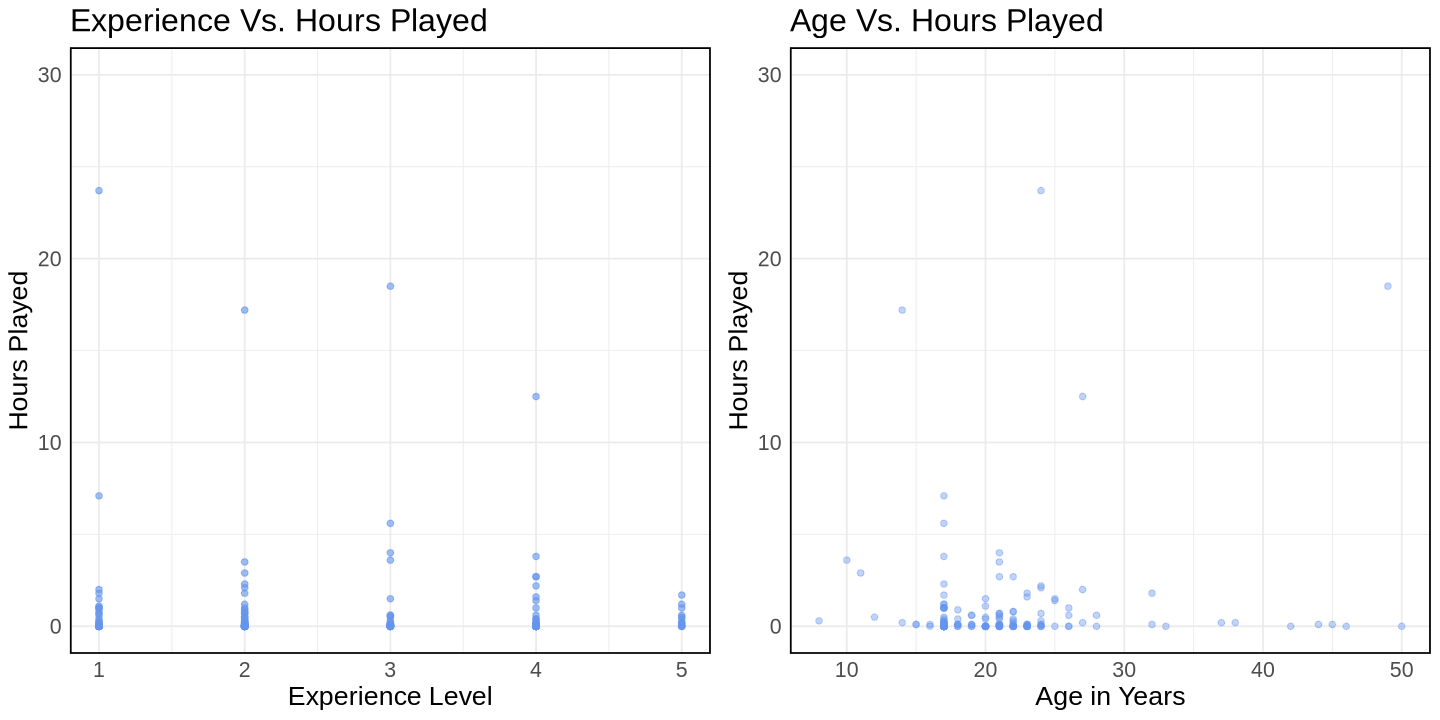

In [129]:
# this is similar to what was done in the invividual portion, but I think it's good to have a starting plot
# so that the reader can follow the process from start to end

options(repr.plot.width = 12, repr.plot.height = 6)

experience_plot <- ggplot(data,aes(x = experience, y = played_hours)) +
    geom_point(alpha = 0.6, color = "cornflowerblue") +
    theme_minimal() +
 scale_y_continuous(limits = c(NA, 30)) +
    labs(title = "Experience Vs. Hours Played", x = "Experience Level", y = "Hours Played") +
    theme(panel.border = element_rect(color = "black", fill = NA, linewidth = 1),
          text = element_text(size = 16))

age_plot <- ggplot(data,aes(x = age, y = played_hours)) +
    geom_point(alpha = 0.4, color = "cornflowerblue") +
    theme_minimal() +
     scale_y_continuous(limits = c(NA, 30)) +
    labs(title = "Age Vs. Hours Played", x = "Age in Years", y = "Hours Played") +
    theme(panel.border = element_rect(color = "black", fill = NA, linewidth = 1),
          text = element_text(size = 16))

plot_grid(experience_plot, age_plot, ncol = 2)

Since there does not appear to be a strong linear relationship in either of the predictors, we will opt for KNN regression as opposed to linear regression. Here we split the tidy data and apply a KNN regression model to the training set. We chose to split it into 25% testing and 75% training because we have a relatively small data set with under 200 observations. We wanted to ensure we could maintain a sizeable testing set to adequately analyze the efficacy of our model at the end. It is also because of this small data set that we chose to use a 5-fold cross validation instead of 10-fold.

In [130]:
 set.seed(69420)
# predict played_hours from experience, Age
# multivariable knn regression gives 3D plots which we were told to avoid :( 
# i think we could evaluate each predictor separately then we can try a multivariable prediction and
# see if combining the variables gives a more accurate model or not.
# otherwise we have nothing to visualize


#split the data into training and testing
data_split <- initial_split(data, prop = 0.75, strata = played_hours)  
data_train <- training(data_split)
data_test <- testing(data_split)

age_recipe <- data_train_recipe <- recipe(played_hours ~ age, data = data_train) |>
    step_scale(all_predictors()) |>
    step_center(all_predictors())

age_spec <- nearest_neighbor(weight_func = "rectangular", neighbors = tune()) |> 
      set_engine("kknn") |>
      set_mode("regression") 

age_vfold <- vfold_cv(data_train, v = 10, strata = played_hours)

age_workflow <- workflow() |>
    add_recipe(age_recipe) |>
    add_model(age_spec)

gridvals <- tibble(neighbors = seq(from = 5, to = 40, by = 5))

age_results <- age_workflow |>
  tune_grid(resamples = age_vfold, grid = gridvals) |>  
    collect_metrics()

age_k_min <- age_results |>
    filter(.metric == "rmse") |>
    slice_min(mean, n=1)

age_k_min

neighbors,.metric,.estimator,mean,n,std_err,.config
<dbl>,<chr>,<chr>,<dbl>,<int>,<dbl>,<chr>
30,rmse,standard,19.66875,10,7.403761,Preprocessor1_Model6


In [131]:
age_min <- age_k_min |>
         pull(neighbors)

age_best_spec <- nearest_neighbor(weight_func = "rectangular", neighbors = age_min) |>
         set_engine("kknn") |>
         set_mode("regression")

age_best_fit <- workflow() |>
         add_recipe(age_recipe) |>
         add_model(age_best_spec) |>
         fit(data = data_train)
#evaluate the model
data_summary <- age_best_fit |>
          predict(data_test) |>
          bind_cols(data_test) |>
          metrics(truth = played_hours, estimate = .pred)
data_summary

.metric,.estimator,.estimate
<chr>,<chr>,<dbl>
rmse,standard,23.90812871
rsq,standard,0.02363702
mae,standard,8.32823129


Now that we have collected summary statistics for our model before and after testing it on `data_test`, we can visualize the model.

Warning message in scale_y_continuous(trans = "log10"):
“log-10 transformation introduced infinite values.”


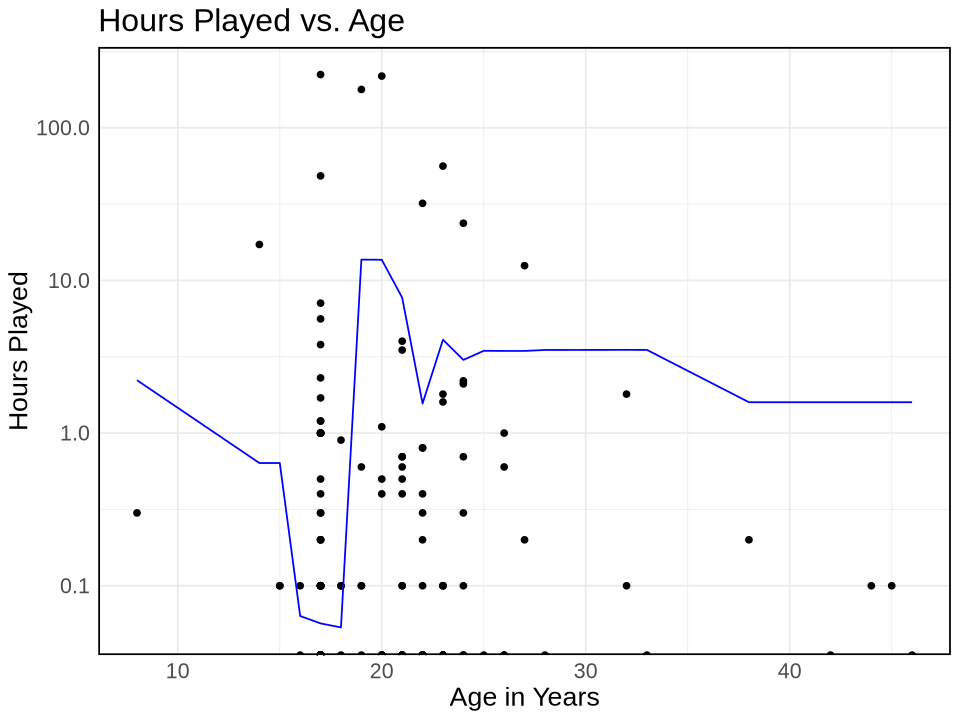

In [132]:
options(repr.plot.width = 8, repr.plot.height = 6)

age_preds <- age_best_fit |>
    predict(data_train)|>
    bind_cols(data_train)

marathon_plot <- age_preds |>
    ggplot(aes(x = age, y = played_hours)) +
    geom_point() +
    theme_minimal() +
    scale_y_continuous(trans = 'log10') +
    geom_line(data = arrange(age_preds, age),
            mapping = aes(x = age, y = .pred),
            color = "blue") +
            labs(x = "Age in Years", y= "Hours Played", title = "Hours Played vs. Age") +
  theme(panel.border = element_rect(color = "black", fill = NA, linewidth = 1),
          text = element_text(size = 16))
marathon_plot

In [133]:
set.seed(69420)

data_train_recipe <- recipe(played_hours ~ experience + age , data = data_train) |>
# step_normalize(all_predictors())
                        # normalizing gives a lower standard error than scale+center,
                        # but either way all the metrics say our model is trash *crying emoji*
    step_scale(all_predictors()) |>
    step_center(all_predictors())
# data_train_recipe


#find optimal k
data_spec <- nearest_neighbor(weight_func = "rectangular", neighbors = tune()) |> 
      set_engine("kknn") |>
      set_mode("regression") 

data_vfold <- vfold_cv(data_train, v = 5, strata = played_hours)

data_workflow <- workflow() |>
    add_recipe(data_train_recipe) |>
    add_model(data_spec)

gridvals <- tibble(neighbors = seq(from = 1, to = 81, by = 5))

k_data_results <- data_workflow |>
  tune_grid(resamples = data_vfold, grid = gridvals) |>  
    collect_metrics()

k_data_min <- k_data_results |>
    filter(.metric == "rmse") |>
    slice_min(mean, n=1)

k_data_min

#for some reason it doesn't like the vfold? or the gridvals...? plz debug

neighbors,.metric,.estimator,mean,n,std_err,.config
<dbl>,<chr>,<chr>,<dbl>,<int>,<dbl>,<chr>
31,rmse,standard,26.34792,5,6.547614,Preprocessor1_Model07


In [134]:
set.seed(69420)

#do the model

k_min <- k_data_min |>
         pull(neighbors)

data_best_spec <- nearest_neighbor(weight_func = "rectangular", neighbors = k_min) |>
         set_engine("kknn") |>
         set_mode("regression")

data_best_fit <- workflow() |>
         add_recipe(data_train_recipe) |>
         add_model(data_best_spec) |>
         fit(data = data_train)
#evaluate the model
data_summary <- data_best_fit |>
          predict(data_test) |>
          bind_cols(data_test) |>
          metrics(truth = played_hours, estimate = .pred)
data_summary

#yeah the data really doesn't like the bind_cols. Similar issue to the code above. 

.metric,.estimator,.estimate
<chr>,<chr>,<dbl>
rmse,standard,24.28227539
rsq,standard,0.01088994
mae,standard,9.96398947


### **Linear Regression**

Now, using the initial split of the dataset we used for the KNN-Regression model, we'll construct our linear regression model and compare errors between the models. 

In [135]:
lm_spec <- linear_reg() |>
  set_engine("lm") |>
  set_mode("regression")

lm_recipe <- recipe(played_hours ~ age, data = data_train)

lm_fit <- workflow() |>
  add_recipe(lm_recipe) |>
  add_model(lm_spec) |>
  fit(data = data_train)

lm_fit

══ Workflow [trained] ══════════════════════════════════════════════════════════
Preprocessor: Recipe
Model: linear_reg()

── Preprocessor ────────────────────────────────────────────────────────────────
0 Recipe Steps

── Model ───────────────────────────────────────────────────────────────────────

Call:
stats::lm(formula = ..y ~ ., data = data)

Coefficients:
(Intercept)          age  
    11.1985      -0.2529  


From our fitted model, we obtain our intercept and slope. The equation for the straight line is then given by 

$$ \text{hours played} = 11.1985  -0.2529 \cdot (\text{age}) $$

This interpretation for this equation is that the model predicts that hours played start at 11.1985 at age zero, and that every one year increase in age nets a 0.2529 hour decrease in hours played. Note that this reasoning is given under the contraints of the dataset. 

Next, we'll calculate the RMSPE and compare it to one produced for our knn model.

In [136]:
lm_test_results <- lm_fit |>
  predict(data_test) |>
  bind_cols(data_test) |>
  metrics(truth = played_hours, estimate = .pred)

lm_test_results

.metric,.estimator,.estimate
<chr>,<chr>,<dbl>
rmse,standard,22.587979372
rsq,standard,0.007369871
mae,standard,9.898088526


Finally, we'll visualize our linear regression model by calculating the minimum and maximum values of our set and connecting it with a straight line.

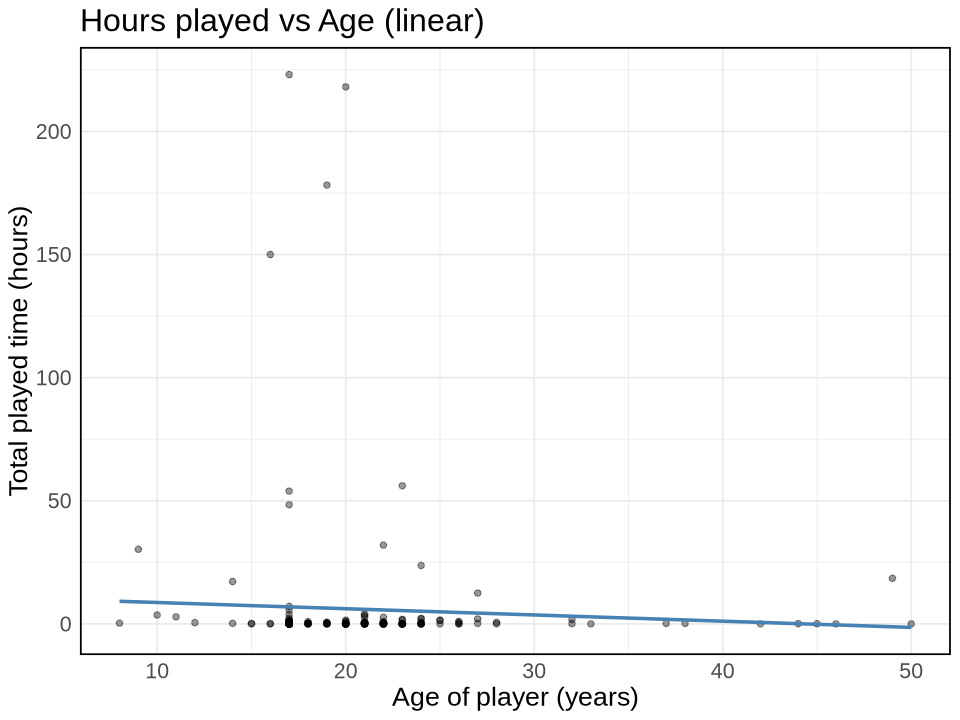

In [139]:
hours_prediction_grid <- tibble(
    age = c(
        data |> select(age) |> min(),
        data |> select(age) |> max()
    )
)

hours_pred <- lm_fit |>
  predict(hours_prediction_grid) |>
  bind_cols(hours_prediction_grid)

plot <- ggplot(data, aes(x = age, y = played_hours)) +
  geom_point(alpha = 0.4) +
  geom_line(data = hours_pred,
            mapping = aes(x = age, y = .pred),
            color = "steelblue",
            linewidth = 1) +
  theme_minimal() + 
  xlab("Age of player (years)") +
  ylab("Total played time (hours)") +
  ggtitle("Hours played vs Age (linear)") +
  theme(panel.border = element_rect(color = "black", fill = NA, linewidth = 1),
          text = element_text(size = 16))

plot

### **Comparison between our Linear Regressison and KNN Regression Models**

The calculated RMSPE models between our linear and KNN regression models are 22.59 and 24.28 respectively. Given RMSPE as our metric, our linear regression model has better performance in this particular case. However, given the constraints of our dataset, we cannot confidently judge which model is better for modeling the relationship in this case. 

Currently, both models are limited by the lack of variety of data relevant to the analysis, which may create large random error in the model. As for the method itself, in the event that the relationship is non-linear, the model may not capture such a relation in a sufficiently accurate manner. It appears that most of the highest time played occurs in roughly the ages 15-27 range. Also, majority of points seem be concentrated at around zero hours played. 

### **Discussion**

 - summarize what you found
 - discuss whether this is what you expected to find?
 - discuss what impact could such findings have?
 - discuss what future questions could this lead to?

### **References**

Introductory GIF: https://giphy.com/gifs/zombie-pit-ensues-ZPQLVgoXJT7K8

Textbook: Timbers, T., Campbell, T., & Lee, M. (2024). Data Science: A First Introduction. In    datasciencebook.ca. CRC Press. https://datasciencebook.ca/


